In [2]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

from binance import Client
from binance.enums import HistoricalKlinesType

### 抓資料並切割樣本

In [3]:
#get binance data


client = Client()
value = client.get_historical_klines(symbol = 'BTCUSDT', 
                                      interval = '15m', 
                                      start_str = '2020-01-01', 
                                      end_str = '2024-01-18',
                                      klines_type=HistoricalKlinesType.FUTURES)

columns_name = ['openTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'closeTime', 
                'quoteVolume', 'numTrade', 'takerBuyVolume', 'takerBuyQuoteVolume', 'ignore']

df = pd.DataFrame(value)
df.columns = columns_name
df['openTime']= pd.to_datetime(df['openTime'], unit='ms')
df = df.drop(['ignore', 'closeTime'], axis=1)
df = df.sort_values('openTime', ascending=True)
df = df.set_index('openTime')
df = df.astype(float)
df = df[~df.index.duplicated(keep='first')]

In [5]:
df.to_csv(f'pricedata_' + interval + '.csv')

NameError: name 'interval' is not defined

In [ ]:
interval = '1h'
df = pd.read_csv('pricedata_' + interval + '.csv')
df['timestamp'] = pd.to_datetime(price_df['timestamp'])
df.set_index('timestamp', inplace=True)
df

In [6]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-12-31'] # in sample data
price_os = price_all['2023-01-01':'2024-01-18'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00:15:00   7176.22   7179.41   7170.69   7172.36
2020-01-01 00:30:00   7172.79   7179.45   7170.61   7174.83
2020-01-01 00:45:00   7174.51   7179.36   7170.15   7171.55
2020-01-01 01:00:00   7171.43   7188.77   7171.10   7186.60
...                       ...       ...       ...       ...
2024-01-17 23:00:00  42727.10  42741.00  42622.40  42723.30
2024-01-17 23:15:00  42723.40  42744.20  42644.70  42715.00
2024-01-17 23:30:00  42715.10  42751.50  42687.30  42718.00
2024-01-17 23:45:00  42718.00  42794.30  42708.60  42783.40
2024-01-18 00:00:00  42783.30  42797.00  42691.40  42711.80

[141889 rows x 4 columns]
                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00

### 定義策略

In [7]:
#double rsi as signal and filter
def rsi_long(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossover & (rsi_filter > 70), 1, 0)
    signal = np.where(rsi_crossunder & (rsi_filter < 30), -1, signal)

    return signal

def rsi_short(close, rsi_window = 29, filter_window = 50):

    rsi_crossover = vbt.RSI.run(close, window=rsi_window).rsi_crossed_above(70).to_numpy()
    rsi_crossunder = vbt.RSI.run(close, window=rsi_window).rsi_crossed_below(30).to_numpy()

    rsi_filter = vbt.RSI.run(close, window = filter_window).rsi.to_numpy()

    signal = np.where(rsi_crossunder & (rsi_filter < 30), 1, 0)
    signal = np.where(rsi_crossover & (rsi_filter > 70), -1, signal)

    return signal

MyInd_long = vbt.IndicatorFactory(
    class_name = 'rsi_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_long, keep_pd=True)

MyInd_short = vbt.IndicatorFactory(
    class_name = 'rsi_short',
    short_name = 'short',
    input_names = ['close'],
    param_names = ['rsi_window', 'filter_window'],
    output_names = ['signals'] 
).from_apply_func(rsi_short, keep_pd=True)


### 參數優化

In [8]:
#run strategy and do parameter optimization on in sample data

win = np.arange(20, 50)
signal = MyInd_short.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio_short = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'shortonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

signal = MyInd_long.run(price_is['Close'] , rsi_window=win, filter_window=win, param_product = True)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio_long = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'longonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio_long.sharpe_ratio().sort_values())
print(portfolio_short.sharpe_ratio().sort_values())

long_rsi_window  long_filter_window
20               20                   -0.551133
21               21                   -0.430759
                 20                   -0.225225
22               22                   -0.116900
23               23                   -0.062374
                                         ...   
26               38                    1.798400
29               41                    1.808101
30               42                    1.815464
32               49                    1.895654
33               37                    1.902586
Name: sharpe_ratio, Length: 900, dtype: float64
short_rsi_window  short_filter_window
20                20                    -1.309497
21                21                    -1.177389
22                22                    -0.906529
21                20                    -0.905161
23                23                    -0.770943
                                           ...   
39                29                     0.742061


In [7]:
pf_long = pd.concat([portfolio_long.total_return(),  portfolio_long.sharpe_ratio()], axis=1)
pf_short = pd.concat([portfolio_short.total_return(),  portfolio_short.sharpe_ratio()], axis=1)

In [8]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

NameError: name 'pf' is not defined

In [9]:
#select strategies with best sharpe ratio
#idx_best_10_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
#idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe_short = pf_short.loc[np.logical_and(pf_short.index.get_level_values(0) > 25, pf_short.index.get_level_values(0) < pf_short.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_sharpe_long = pf_long.loc[np.logical_and(pf_long.index.get_level_values(0) > 25, pf_long.index.get_level_values(0) < pf_long.index.get_level_values(1))].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
#idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
#print("best 10 sharpe: " + str(idx_best_10_sharpe))
#print("best 10 return: " + str(idx_best_10_return))
print("best 5 sharpe short: " + str(idx_best_5_sharpe_short))
print("best 5 sharpe long: " + str(idx_best_5_sharpe_long))
#print("best 5 return: " + str(idx_best_5_return))

best 5 sharpe short: [(27, 44), (27, 45), (26, 39), (30, 47), (32, 37)]
best 5 sharpe long: [(33, 37), (32, 49), (30, 42), (29, 41), (26, 38)]


In [10]:
entries_list = []
exits_list = []

for param in idx_best_5_sharpe_short:

    signal = MyInd_short.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio_short = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'shortonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio_short.returns())

entries_list = []
exits_list = []

for param in idx_best_5_sharpe_long:

    signal = MyInd_long.run(price_all['Close'] , rsi_window=param[0], filter_window=param[1], param_product = True)

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio_long = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio_long.returns())

                       27          26    30    32
                       44    45    39    47    37
                    Close Close Close Close Close
openTime                                         
2020-01-01 00:00:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:15:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:30:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 00:45:00   0.0   0.0   0.0   0.0   0.0
2020-01-01 01:00:00   0.0   0.0   0.0   0.0   0.0
...                   ...   ...   ...   ...   ...
2023-12-06 23:00:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:15:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:30:00   0.0   0.0   0.0   0.0   0.0
2023-12-06 23:45:00   0.0   0.0   0.0   0.0   0.0
2023-12-07 00:00:00   0.0   0.0   0.0   0.0   0.0

[137857 rows x 5 columns]
                           33        32        30        29        26
                           37        49        42        41        38
                        Close     Close     Close     Close     Close
openTime     

,"(27, 44, Close)","(27, 45, Close)","(26, 39, Close)","(30, 47, Close)","(32, 37, Close)","(33, 37, Close)","(32, 49, Close)","(30, 42, Close)","(29, 41, Close)","(26, 38, Close)","(rp, , )","(eq, , )","(shortonly, , )","(longonly, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07,2023-12-07
Risk-Free Rate,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Time in Market,0.27,0.29,0.32,0.29,0.38,0.5,0.45,0.49,0.46,0.5,0.06,0.98,0.51,0.66
Cumulative Return,1.22,1.23,0.65,0.5,0.7,25.73,18.03,15.28,20.52,17.99,0.15,6.26,0.92,20.2
CAGR﹪,0.15,0.15,0.09,0.07,0.1,0.78,0.68,0.63,0.71,0.68,0.02,0.42,0.12,0.71
Sharpe,0.8,0.8,0.53,0.49,0.55,2.11,1.99,1.88,2.08,1.97,0.59,2.23,0.71,2.15
Prob. Sharpe Ratio,0.95,0.94,0.86,0.83,0.86,1.0,1.0,1.0,1.0,1.0,0.88,1.0,0.92,1.0
Smart Sharpe,0.8,0.8,0.53,0.48,0.55,2.09,1.99,1.88,2.08,1.96,0.59,2.22,0.71,2.14
Sortino,1.18,1.17,0.77,0.7,0.8,3.01,2.82,2.65,2.94,2.79,0.86,3.19,1.04,3.05


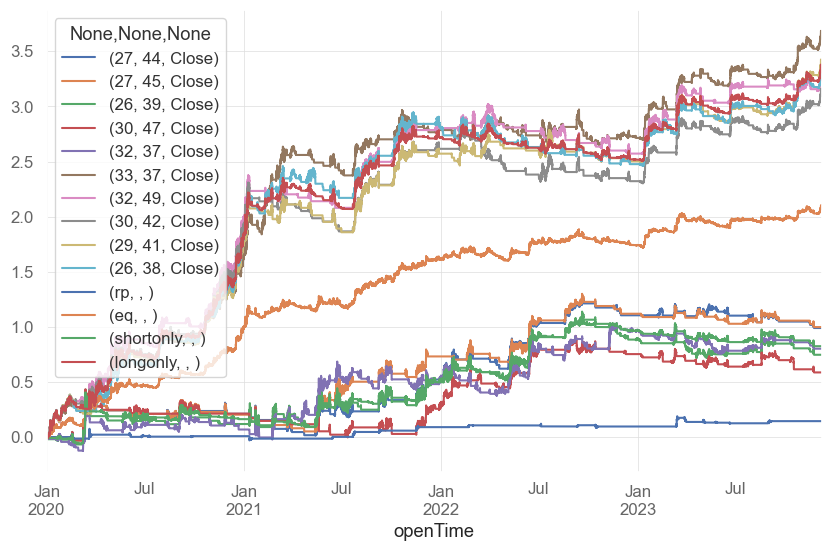

In [12]:
rett_s = portfolio_short.returns()
rett_l = portfolio_long.returns()

rett = pd.concat([rett_s, rett_l], axis=1)

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis=1)
rett['eq'] = rett.iloc[:, :10].mean(axis = 1)
rett['shortonly'] = rett.iloc[:, :5].mean(axis = 1)
rett['longonly'] = rett.iloc[:, 5:10].mean(axis = 1)

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year =4 * 24 * 365)

df_metrics.head(50)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

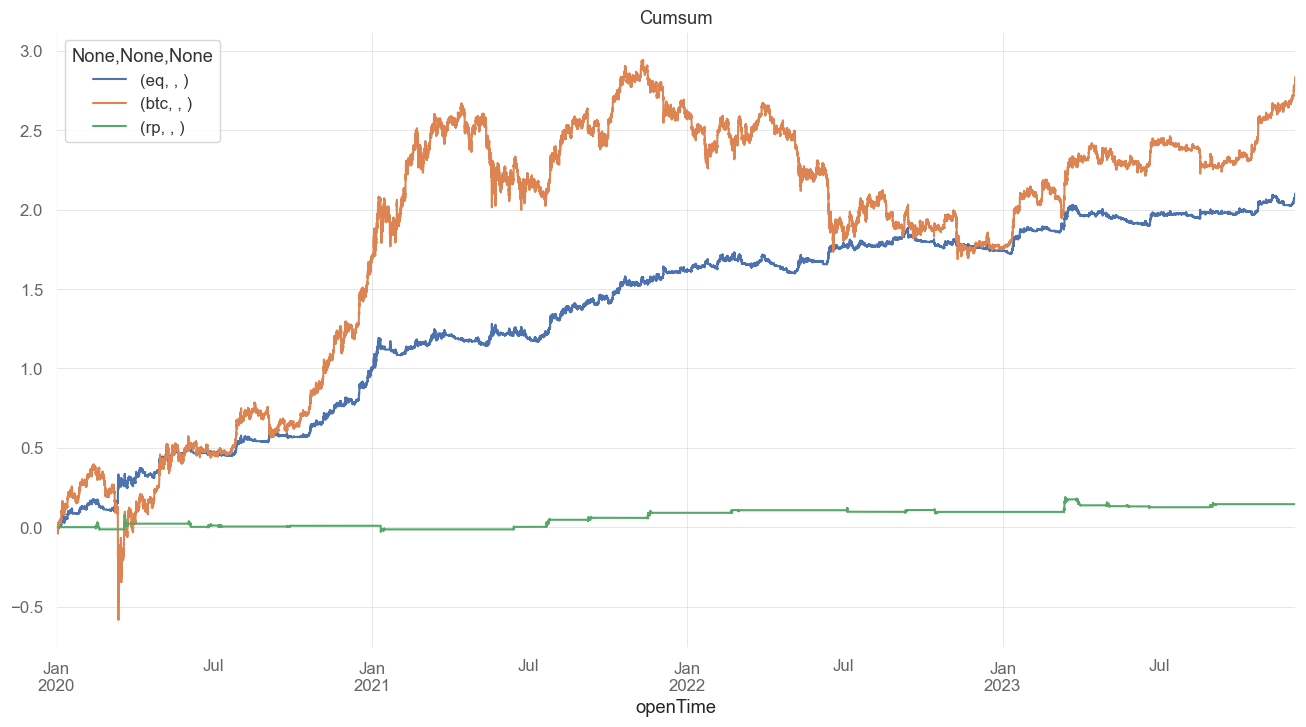

In [13]:
from datetime import datetime

rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')

In [14]:
qs_metrics = pd.DataFrame()

qs_metrics["benchmark"] = qs.reports.metrics(rett['btc'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded=False)
qs_metrics["eq_in_sample"] = qs.reports.metrics(rett['eq']['2020-01-01':'2022-12-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_out_sample"] = qs.reports.metrics(rett['eq']['2023-01-01':'2023-12-07'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["eq_all"] = qs.reports.metrics(rett['eq'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_in_sample"] = qs.reports.metrics(rett['rp']['2020-01-01':'2022-12-31'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_out_sample"] = qs.reports.metrics(rett['rp']['2023-01-01':'2023-12-07'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)
qs_metrics["rp_all"] = qs.reports.metrics(rett['rp'], mode='full', display=False, periods_per_year =4 * 24 * 365, compounded = False)


In [15]:
qs_metrics.head(60)
#qs_metrics.to_csv('metrics.csv')

,benchmark,eq_in_sample,eq_out_sample,eq_all,rp_in_sample,rp_out_sample,rp_all
Start Period,2020-01-01,2020-01-01,2023-01-01,2020-01-01,2020-01-01,2023-01-01,2020-01-01
End Period,2023-12-07,2022-12-31,2023-12-07,2023-12-07,2022-12-31,2023-12-07,2023-12-07
Risk-Free Rate,0,0,0,0,0,0,0
Time in Market,1.0,0.97,0.98,0.98,0.05,0.07,0.06
Total Return,2.82,1.74,0.35,2.09,0.1,0.05,0.14
CAGR﹪,0.27,0.26,0.25,0.22,0.02,0.04,0.02
Sharpe,1.0,2.29,2.07,2.23,0.52,0.82,0.59
Prob. Sharpe Ratio,0.98,1.0,0.98,1.0,0.81,0.79,0.88
Smart Sharpe,1.0,2.29,2.0,2.22,0.51,0.79,0.59
Sortino,1.42,3.25,3.09,3.19,0.74,1.28,0.86


In [1]:
qs.reports.full(rett['eq'], benchmark = rett['btc'], periods_per_year= 4 * 24 *365, compounded=True)

NameError: name 'qs' is not defined